In [1]:
import matplotlib.pyplot as plt
import numpy as np
from zlib import adler32
import requests
import networkx as nx
from scipy.stats import ks_2samp
import random
from sklearn.preprocessing import minmax_scale
import itertools

In [2]:
import json
with open('stats.txt', 'r') as f:
    d = json.load(f)

In [3]:
d

{'number_nodes': 1882,
 'radius': [15, 2],
 'diameter': [28, 4],
 'average_clustering': [0.005066798238955518, 0.001],
 'average_path_length': [11.748410823170731, 2],
 'number_cc': [168, 32],
 'degree_cdf': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   19,
   21,
   24,
   46],
  [0.0,
   0.6902231668437833,
   0.8517534537725824,
   0.9086078639744952,
   0.9378320935175345,
   0.9516471838469713,
   0.9654622741764081,
   0.9723698193411264,
   0.9776833156216791,
   0.9808714133900106,
   0.9845908607863975,
   0.9888416578108395,
   0.9893730074388948,
   0.9925611052072264,
   0.9936238044633369,
   0.9952178533475027,
   0.9957492029755579,
   0.9968119022316685,
   0.997874601487779,
   0.9989373007438895,
   0.9994686503719448,
   1.0]]}

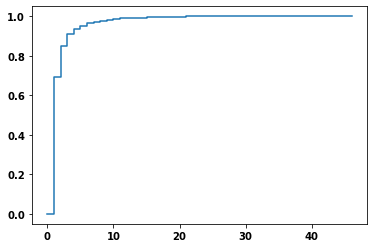

In [4]:
q_seq, p_seq = d['degree_cdf']
plt.plot(
    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]), 
    np.repeat(p_seq, 2)
)
plt.show()

In [5]:
density = [round(1882 * (p_seq[i+1] - p_seq[i])) for i in range(len(p_seq) - 1)]
degrees_input = {}
for i in range(len(density)):
    degrees_input[q_seq[i + 1]] = density[i]
degrees_input

{1: 1299,
 2: 304,
 3: 107,
 4: 55,
 5: 26,
 6: 26,
 7: 13,
 8: 10,
 9: 6,
 10: 7,
 11: 8,
 12: 1,
 13: 6,
 14: 2,
 15: 3,
 16: 1,
 17: 2,
 19: 2,
 21: 2,
 24: 1,
 46: 1}

In [8]:
print("Number of edges:", int(sum(degrees_input.values()) / 2))

Number of edges: 941


In [9]:
print("Number of nodes:", d['number_nodes'])

Number of nodes: 1882


In [34]:
print("Average number of angles for one triangle:", 3 / d['average_clustering'][0])

Average number of angles for one triangle: 592.0898876404495


***Load graph***

In [11]:
G = nx.read_adjlist("output_great6.txt")

In [2]:
# degree_sequence_1 = []
# for node in range(d['number_nodes']):
#     r = random.random()
#     value = cdf[1][0]
#     for i, j in enumerate(cdf[1]):
#         if j < r:
#             value = cdf[0][i + 1]
#     degree_sequence_1.append(value)

In [3]:
# G1 = nx.Graph(nx.configuration_model(degree_sequence_1, create_using=nx.Graph))

In [4]:
# m = sum(degree_sequence_1) / d['number_nodes']

In [12]:
G_giant = G.subgraph(max(nx.connected_components(G), key=len)).copy()

***BA***

In [13]:
def attach(node, G, m):
    bst = []
    for u, v in G.edges:                                      
        bst.append(u)
        bst.append(v)
    added_edges = 0
    while added_edges < m:
        v = random.choice(bst)
        if not G.has_edge(node, v):
            G.add_edge(node, v)
            added_edges += 1

def barabasi_albert_graph(n, m, random_seed=1):
    G = nx.star_graph(m)
    for i in range(1, n - m):
        attach(m + i, G, m)
    return G

In [76]:
G_ba = barabasi_albert_graph(d['number_nodes'], 2)

***SW***

In [17]:
def adjacent_edges(nodes, halfk):
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v


def ring_lattice(n, k):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in G.nodes:
        rewire(G, node, k, p)
    return G

def rewire(G, node, k, p):
    nodes = np.array(G.nodes)
    neighbour_nodes = list(G[node])[k//2:]
    for neighbour_node in neighbour_nodes:
        if random.random() >= p:
            continue
            
        G.remove_edge(node, neighbour_node)
        while True:
            new_node = random.choice(nodes)
            if not G.has_edge(node, new_node) and new_node != neighbour_node:
                G.add_edge(node, new_node)
                break

In [9]:
# G_sw = watts_strogatz_graph(n, 3, 0.95)
# G_giant_sw = G_sw.subgraph(max(nx.connected_components(G_sw), key=len)).copy()

In [11]:
# len(list(nx.connected_components(G_sw))), nx.average_clustering(G_giant_sw), nx.average_shortest_path_length(G_giant_sw), nx.radius(G_giant_sw), nx.diameter(G_giant_sw)

In [12]:
# len(list(G_sw.edges))

***Graphs combination***

***Finding the giant component iteratevely by Wattz-Strogatz graph***

In [442]:
# grid = {
#     'n': range(250, 400, 10),
#     'm': range(2, 5),
#     'p': range(5, 95, 5)
# }

grid = {
    'n': [250],
    'm': [2],
    'p': [0.6]
}


def find_params():
    for n in grid['n']:
        for m in grid['m']:
            for p in grid['p']:
                G1 = watts_strogatz_graph(n, m, p)
                G_giant_1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
                for i in range(100000):
                    G1 = watts_strogatz_graph(n, m, p)
                    G_giant_1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
                    if nx.radius(G_giant_1) == 15 and nx.diameter(G_giant_1) == 28 and (11.6 <= nx.average_shortest_path_length(G_giant_1) <= 11.8):
                        return G1, n, m, p, nx.radius(G_giant_1), nx.diameter(G_giant_1), len(G_giant_1.nodes), nx.average_clustering(G1), nx.average_shortest_path_length(G_giant_1)

ress = find_params()

250 2 0.6
250 2 0.6 21 42 206 0.002933333333333333 12.910774331044282
! 250 2 0.6 15 28 197 0.009333333333333332 11.744794364446285


In [951]:
G1 = ress[0].copy()

In [952]:
G_giant_1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
print(nx.radius(G_giant_1), nx.diameter(G_giant_1), len(G_giant_1.nodes), nx.average_clustering(G1), nx.average_shortest_path_length(G_giant_1))             

15 28 197 0.009333333333333332 11.744794364446285


In [445]:
len(list(nx.connected_components(G1)))

13

In [35]:
# nx.average_clustering(G_giant_1)

In [36]:
# len(list(nx.connected_components(G1))), nx.average_clustering(G_giant_1), nx.average_shortest_path_length(G_giant_1), nx.radius(G_giant_1), nx.diameter(G_giant_1)

In [975]:
degree_big_component = []
for item in G1.degree:
    degree_big_component.append(item[1])
from collections import Counter
degrees_dict_giant = dict(Counter(degree_big_component))

degrees_razn = {}
for key, value in degrees_input.items():
    degrees_razn[key] = value - degrees_dict_giant.get(key, 0)

In [1181]:
Gr_added = nx.relabel_nodes(G1, {i: 100000 + i for i in range(197)})
tt = 0
tt2 = 0
number = 1000
for key, value in degrees_razn.items():
    if key > 1:
        if key == 2:
            gr = nx.relabel_nodes(ring_lattice(135, 2), {i: number + i for i in range(135)})
            number += 135
            Gr_added = nx.compose(Gr_added, gr)
            subg = Gr_added.subgraph(max(nx.connected_components(Gr_added), key=len)).copy()
            for _ in range(7):
                gr = nx.relabel_nodes(nx.path_graph(3), {i: number + i for i in range(3)})
                number += 3
                Gr_added = nx.compose(Gr_added, gr)
            for _ in range(0):
                gr = nx.relabel_nodes(nx.path_graph(2), {i: number + i for i in range(2)})
                number += 2
                Gr_added = nx.compose(Gr_added, gr)
        elif key == 3:
            gr = nx.relabel_nodes(ring_lattice(55, 2), {i: number + i for i in range(55)})
            number += 55
            nds = list(gr.nodes)
            for node in nds:                    
                gr.add_node(number)
                gr.add_edge(node, number)
                number += 1
            for node in nds:
                if tt2 < 6:            
                    gr.add_node(number + 1)
                    gr.add_node(number + 2)
                    gr.add_edge(number, number + 1)
                    gr.add_edge(number, number + 2)
                    number += 2
                    tt2 += 1
            Gr_added = nx.compose(Gr_added, gr)
        elif key == 5:
            print(value)
            for _ in range(3):
                gr = nx.relabel_nodes(nx.star_graph(key), {i: number + i for i in range(key + 1)})
                number += key + 1
                Gr_added = nx.compose(Gr_added, gr)
        elif key != 4:
            for _ in range(value):
                gr = nx.relabel_nodes(nx.star_graph(key), {i: number + i for i in range(key + 1)})
                number += (key + 1)
                Gr_added = nx.compose(Gr_added, gr)
        else:
            for _ in range(42):
                gr = nx.relabel_nodes(nx.star_graph(key), {i: number + i for i in range(key + 1)})
                number += (key + 1)
                Gr_added = nx.compose(Gr_added, gr)
            gr = nx.relabel_nodes(ring_lattice(12, 2), {i: number + i for i in range(12)})
            number += 12
            nds = list(gr.nodes)
            for node in nds:
                gr.add_edge(node, (node + 6) % 12)
            for node in nds:
                gr.add_nodes_from(list(range(number, number + 2)))
                gr.add_edge(node, number)
                gr.add_edge(node, number + 1)
                if tt < 2:
                    gr.add_edge(number, number + 1)
                    tt += 1
                number += 2
            Gr_added = nx.compose(Gr_added, gr)
gr = nx.relabel_nodes(nx.cycle_graph(3), {i: number + i for i in range(3)})
number += 3
Gr_added = nx.compose(Gr_added, gr)



gr = nx.relabel_nodes(nx.path_graph(14), {i: number + i for i in range(14)})
number += 14
kk = 0
nodess = list(gr.nodes)
for kk, node in enumerate(nodess):
    if kk < 10:
        gr.add_nodes_from(list(range(number, number + 3)))
        gr.add_edge(node, number)
        gr.add_edge(node, number + 1)
        gr.add_edge(node, number + 2)
        number += 3
    elif kk < 12:
        gr.add_nodes_from(list(range(number, number + 2)))
        gr.add_edge(node, number)
        gr.add_edge(node, number + 1)
        number += 2
        if k == 10: 
            gr.add_edge(number, number + 1)
    elif kk < 15:
        gr.add_nodes_from(list(range(number, number + 1)))
        gr.add_edge(node, number)
        number += 1
Gr_added = nx.compose(Gr_added, gr)


for _ in range(6):
    gr = nx.relabel_nodes(nx.cycle_graph(4), {i: number + i for i in range(4)})
    number += 4
    Gr_added = nx.compose(Gr_added, gr)

gr = nx.relabel_nodes(nx.cycle_graph(8), {i: number + i for i in range(8)})
number += 8
Gr_added = nx.compose(Gr_added, gr)

25


In [1182]:
subg = Gr_added.subgraph(max(nx.connected_components(Gr_added), key=len)).copy()
len(subg.nodes)

197

In [1183]:
subg = Gr_added.subgraph(max(nx.connected_components(Gr_added), key=len)).copy()
len(list(nx.connected_components(Gr_added))), nx.average_clustering(Gr_added), nx.average_shortest_path_length(G_giant_1), nx.radius(G_giant_1), nx.diameter(subg)

(168, 0.005065533120793482, 11.744794364446285, 15, 28)

In [1184]:
degrees_razn2 = {}
for key, value in degrees_input.items():
    degrees_razn2[key] = value - Counter(dict(Gr_added.degree).values()).get(key, 0)

degrees_razn2

{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 19: 0,
 21: 0,
 24: 0,
 46: 0}

In [1185]:
len(Gr_added.nodes)

1882

In [1186]:
d['number_cc'][0] - len(list(nx.connected_components(Gr_added)))

0

In [903]:
d['number_cc'][0], len(list(nx.connected_components(Gr_added)))

(168, 168)

In [907]:
# G_giant_2 = G_giant_1.copy()
# for node in 
# G_giant_2.remove_edge(44, 45)
nx.average_clustering(Gr_added)

0.005065533120793482

In [856]:
A = nx.to_numpy_array(gr)
for i in range(A.shape[0]):
    for j in range(A.shape[0]):
        if A[i, j] == 1:
            for k in range(A.shape[0]):
                if k != i and k != j and A[i, k] == 1 and A[j, k] == 1:
                    print(i, j, k)

12 13 54
12 13 55
12 54 13
12 55 13
13 12 54
13 12 55
13 14 54
13 54 12
13 54 14
13 55 12
14 13 54
14 15 54
14 54 13
14 54 15
15 14 54
15 54 14
54 12 13
54 13 12
54 13 14
54 14 13
54 14 15
54 15 14
55 12 13
55 13 12


In [524]:
list(G_giant_2.nodes)[26: 28]

[44, 45]

In [300]:
kk = 0
for nodee, vall in dict(G_giant_2.degree).items():
    if vall == 1:


dict_values([1, 3, 5, 2, 1, 2, 4, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 3, 2, 2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 3, 1, 2, 4, 1, 3, 2, 2, 2, 2, 1, 1, 3, 1, 5, 2, 2, 1, 2, 3, 4, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 4, 2, 1, 4, 3, 2, 2, 2, 1, 4, 3, 2, 1, 3, 1, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 2, 3, 2, 2, 2, 1, 3, 1, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 1, 3, 1, 2, 2, 1, 3, 1, 5, 2, 2, 2, 3, 2, 3, 1, 2, 2, 3, 2, 3, 2, 2, 2, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 1, 3, 1, 2, 2, 2, 2, 3, 4, 2, 2, 2, 3, 2, 1, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 1, 3, 2, 1, 3, 1, 3])

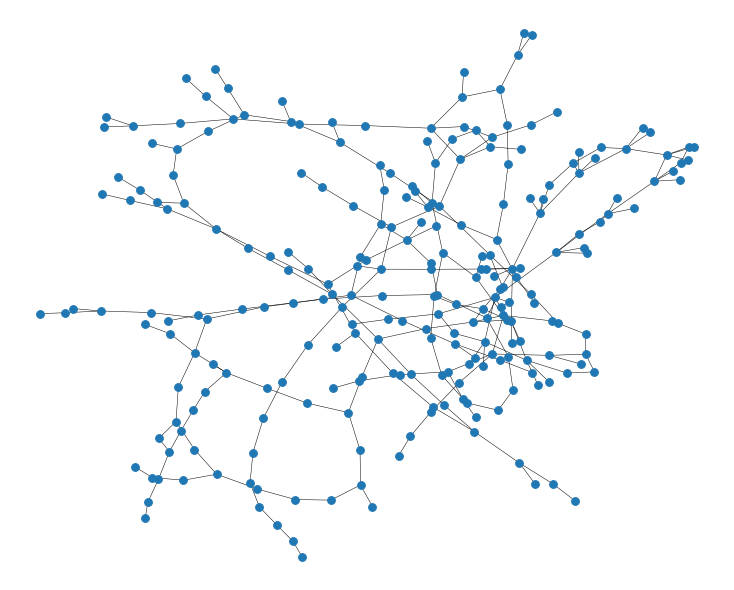

0.0

In [938]:
number = 0
gr = nx.relabel_nodes(nx.path_graph(18), {i: number + i for i in range(18)})
number += 18
kk = 0
nodess = list(gr.nodes)
for kk, node in enumerate(nodess):
    if kk < 12:
        gr.add_nodes_from(list(range(number, number + 3)))
        gr.add_edge(node, number)
        gr.add_edge(node, number + 1)
        gr.add_edge(node, number + 2)
        number += 3
    elif kk < 14:
        gr.add_nodes_from(list(range(number, number + 2)))
        gr.add_edge(node, number)
        gr.add_edge(node, number + 1)
        number += 2
    elif kk < 16:
        gr.add_nodes_from(list(range(number, number + 1)))
        gr.add_edge(node, number)
        number += 1
# Gr_added = nx.compose(Gr_added, gr)
plt.figure(figsize=(10, 8))
nx.draw(subg, 
        width=0.5,
        node_size=60)
plt.show()
nx.average_clustering(gr)

0.0

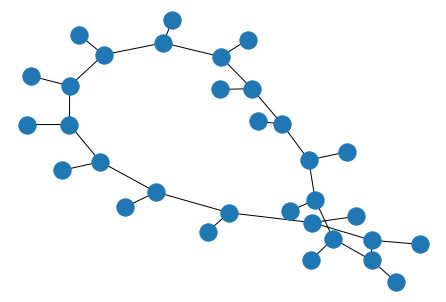

In [470]:
number = 0
gr = nx.relabel_nodes(ring_lattice(16, 2), {i: number + i for i in range(16)})
number += 16
nds = list(gr.nodes)
for node in nds:
    gr.add_nodes_from([number])
    gr.add_edge(node, number)
#     gr.add_edge(node, number + 1)
#     if tt < 7:
#         gr.add_edge(number, number + 1)
#         tt += 1
#     if tt >= 7 and tt < 9:
        
    number += 1
# Gr_added = nx.compose(Gr_added, gr)
nx.draw(gr)
nx.average_clustering(gr)

In [441]:
nx.average_clustering(Gr_added)

0.013336875664187035

In [437]:
# G_add_4 = ring_lattice(53, 2)
# number = 100
# nds = list(G_add_4.nodes)
# for node in nds:
#     G_add_4.add_nodes_from(list(range(number, number + 2)))
#     G_add_4.add_edge(node, number)
#     G_add_4.add_edge(node, number + 1)
#     number += 2

In [440]:
d

{'number_nodes': 1882,
 'radius': [15, 2],
 'diameter': [28, 4],
 'average_clustering': [0.005066798238955518, 0.001],
 'average_path_length': [11.748410823170731, 2],
 'number_cc': [168, 32],
 'degree_cdf': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   19,
   21,
   24,
   46],
  [0.0,
   0.6902231668437833,
   0.8517534537725824,
   0.9086078639744952,
   0.9378320935175345,
   0.9516471838469713,
   0.9654622741764081,
   0.9723698193411264,
   0.9776833156216791,
   0.9808714133900106,
   0.9845908607863975,
   0.9888416578108395,
   0.9893730074388948,
   0.9925611052072264,
   0.9936238044633369,
   0.9952178533475027,
   0.9957492029755579,
   0.9968119022316685,
   0.997874601487779,
   0.9989373007438895,
   0.9994686503719448,
   1.0]]}

In [1187]:
with open('output_great6.txt', 'w') as f_ou:
    for edge in Gr_added.edges:
        f_ou.write(' '.join(map(str, edge)) + '\n')